[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eGXFAsHHrz9xXfJJv7E_TpDLZffCi8dD?authuser=3)

   Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0  Female     Yes         3+      Graduate            No           4165.0   
1    Male      No          0  Not Graduate           Yes           8123.0   
2  Female     NaN          0      Graduate            No           6719.0   
3    Male     Yes          1      Graduate            No           9915.0   
4    Male     Yes          0      Graduate            No           1130.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0              805.0       232.5               360             0.0   
1                0.0       101.6               360             1.0   
2             2793.0       180.2               360             0.0   
3             3287.0       193.1               360             1.0   
4              448.0       170.2               360             1.0   

  Property_Area Loan_Status  
0         Rural           Y  
1         Urban           Y  
2         Urban           

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression + SMOTE ===
Accuracy: 0.593
              precision    recall  f1-score   support

Rejected (0)       0.21      0.35      0.26        26
Approved (1)       0.79      0.66      0.72        97

    accuracy                           0.59       123
   macro avg       0.50      0.50      0.49       123
weighted avg       0.67      0.59      0.62       123


=== Decision Tree (depth=5) + SMOTE ===
Accuracy: 0.732
              precision    recall  f1-score   support

Rejected (0)       0.27      0.15      0.20        26
Approved (1)       0.80      0.89      0.84        97

    accuracy                           0.73       123
   macro avg       0.53      0.52      0.52       123
weighted avg       0.68      0.73      0.70       123



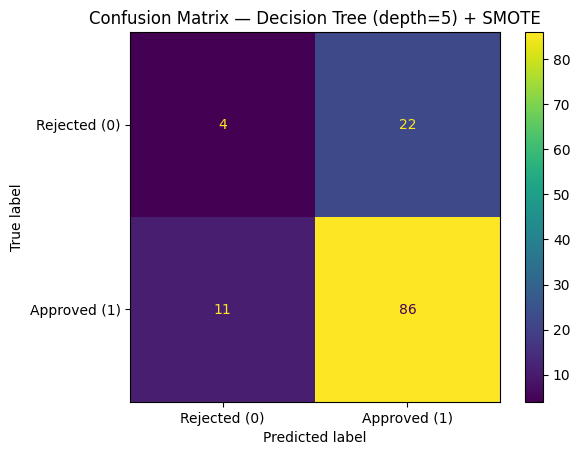

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

USE_GITHUB = True
GITHUB_CSV_URL = "https://raw.githubusercontent.com/zoyarattani/Elevvo-Pathways-Machine-Learning-Internship-Tasks/refs/heads/main/loan_approval.csv"

if USE_GITHUB:
    df = pd.read_csv(GITHUB_CSV_URL)
else:
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv("loan_approval.csv")

print(df.head())
print("\nMissing values:\n", df.isnull().sum())
print("\nClass balance:\n", df["Loan_Status"].value_counts(normalize=True))

y = df["Loan_Status"].map({"Y": 1, "N": 0}).astype(int)
X = df.drop(columns=["Loan_Status"])

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=2000))
])

tree = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", DecisionTreeClassifier(random_state=42, max_depth=5))
])

models = {
    "Logistic Regression + SMOTE": log_reg,
    "Decision Tree (depth=5) + SMOTE": tree
}

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", f"{acc:.3f}")
    print(classification_report(y_test, y_pred, target_names=["Rejected (0)","Approved (1)"]))
    results[name] = (acc, y_pred)

best_name = max(results.keys(), key=lambda k: results[k][0])
best_pred = results[best_name][1]
cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Rejected (0)","Approved (1)"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix — {best_name}")
plt.show()
